<a href="https://colab.research.google.com/github/jhenderson0/jh_ucl_HPC/blob/main/Lesson%203/Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class 3

In [1]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-a9a81b37-8d11-5f84-ab52-6f232ad80067
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Background

$$\sum_j c_jg\left(\mathbf{x},\mathbf{y}_j\right)$$

Where $g$ is a “kernel” function, $\mathbf{x}$ is a point in $\mathbb{R}^3$, $y_0,y_1,...,y_{n-1}$  are (known) points in $\mathbb{R}^3$, and $c_0,c_1,...,c_{n-1}$ are (known) values in $\mathbb{C}$.

In this class, we’re going to use the acoustic Green’s function:

$$g\left(\mathbf{x},\mathbf{y}\right) = \frac{1}{4\pi|x-y|}e^{-ik|x-y|}$$

where $k$ is the wavenumber of the wave. This is the acoustic wave due to a point source: if there are point sources at points $y_0,y_1,...,y_{n-1}$ of sizes $c_0,c_1,...,c_{n-1}$ , then the sum above can be used to compute the magnitude of a (time-harmonic) acoustic wave at each point.




## Plotting some waves

There is a point source with wavenumber 10 at the point $(-1.2,0,0)$  with magnitude 1. The following code plots a slice through the wave due to this source in the plane $z=0$ with $0 \leq x \leq 3$  and $-3/2 \leq y \leq 3/2$.

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [7]:
def g(x, y):
    """Evaluate real part of the acoustic Green's function."""
    return np.cos(k * np.linalg.norm(x - y)) / 4 / np.pi / np.linalg.norm(x - y)

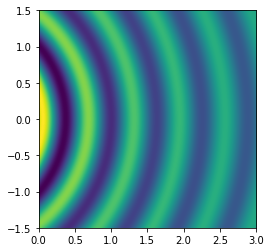

In [8]:
k = 10.
sources = np.array([[-1.2, 0., 0.]])
magnitudes = np.array([1.0])

img_size = 250
values = np.empty((img_size, img_size), dtype="complex128")

xmin = 0
xmax = 3
ymin = -1.5
ymax = 1.5

# plt.imshow interprets data as the colour of pixels starting at the top left then 
# row by row. For example, if an image was 5 pixels wide, the order of the pixels
# would be:
# 0 1 2 3 4
# 5 6 7 8 9
# etc
# Due to this ordering, the y values here might at first glance appear to be backwards

for i in range(img_size):
    y = ymax + (ymin - ymax) * i / (img_size - 1)
    for j in range(img_size):
        x = xmin + (xmax - xmin) * j / (img_size - 1)
        point = np.array([x, y, 0])
        v = 0
        for m, s in zip(magnitudes, sources):
            v += m * g(s, point)
        values[i, j] = v     

plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
plt.show()

Adapt this code so that it plots the real part of a wave due to two point sources with magnitude 1 at the points $(-1.2,0.5,0)$ and $(-1.2,-0.5,0)$ .



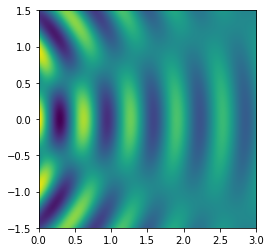

In [10]:
k = 10.
sources = np.array([[-1.2, 0.5, 0.],[-1.2, -0.5, 0.]])
magnitudes = np.array([1.0,1.0])

img_size = 250
values = np.empty((img_size, img_size), dtype="complex128")

xmin = 0
xmax = 3
ymin = -1.5
ymax = 1.5

# plt.imshow interprets data as the colour of pixels starting at the top left then 
# row by row. For example, if an image was 5 pixels wide, the order of the pixels
# would be:
# 0 1 2 3 4
# 5 6 7 8 9
# etc
# Due to this ordering, the y values here might at first glance appear to be backwards

for i in range(img_size):
    y = ymax + (ymin - ymax) * i / (img_size - 1)
    for j in range(img_size):
        x = xmin + (xmax - xmin) * j / (img_size - 1)
        point = np.array([x, y, 0])
        v = 0
        for m, s in zip(magnitudes, sources):
            v += m * g(s, point)
        values[i, j] = v     

plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
plt.show()

Adapt this code so that it plots the real part of a wave due to four point sources with random magnitudes between 0 and 1 at the points random points in the area $x=-1.2$ , $-1 \leq y \leq 1$, $-1 \leq z \leq 1$.



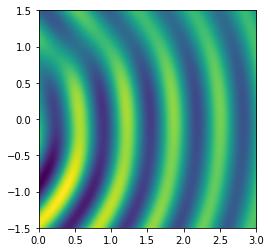

In [12]:
k = 10.
sources = np.array([[-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)]])

magnitudes = np.array([np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1)])

img_size = 250
values = np.empty((img_size, img_size), dtype="complex128")

xmin = 0
xmax = 3
ymin = -1.5
ymax = 1.5

# plt.imshow interprets data as the colour of pixels starting at the top left then 
# row by row. For example, if an image was 5 pixels wide, the order of the pixels
# would be:
# 0 1 2 3 4
# 5 6 7 8 9
# etc
# Due to this ordering, the y values here might at first glance appear to be backwards

for i in range(img_size):
    y = ymax + (ymin - ymax) * i / (img_size - 1)
    for j in range(img_size):
        x = xmin + (xmax - xmin) * j / (img_size - 1)
        point = np.array([x, y, 0])
        v = 0
        for m, s in zip(magnitudes, sources):
            v += m * g(s, point)
        values[i, j] = v     

plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
plt.show()

# GPU acceleration

Write a new version of the code for four sources that runs on a GPU using Numba’s Cuda functionality. You should use blocks of 16 by 4 threads (I picked 4 as this is the number of sources), and an appropriately sized grid so that there is a thread for each point you want to compute the wave at.

You may use the function rbf_evaluation_cuda from the lecture notes section GPU accelerated evaluation of particle sums) as inspiration for your function. The function in the lecture notes uses the following features of numba.cuda that we didn’t use in the lecture:

cuda.shared.array creates a shared array. This array can then be used by threads in the same block.

cuda.grid returns the current thread’s absolute position in entire grid of threads. For a two-dimensional

cuda.syncthreads synchronises all the threads in the same block. This allows you to ensure that all the threads are ready to perform the next operation at the same time (which is important as a GPU will perform best if all the threads in a block are performing the same operation).

cuda.threadIdx.x and cuda.threadIdx.y get the position of the current thread in the current block of threads.

You may wish to create an array of points that you want to evaluate the wave at rather than computing x and y inside the loops, you could do this either by using two for loops to generate the points or by using np.mgrid and ravel as done in the GPU accelerated evaluation of particle sums) section.

Create a plot using single precision floating points numbers using your Cuda-accelerated function and a plot using double precision numbers using the standard Python code above. Visually compare the two plots: can you see any differences?

In [13]:
def g_cuda(x, y):
    """Evaluate real part of the acoustic Green's function."""
    return np.cos(k * np.linalg.norm(x - y)) / 4 / np.pi / np.linalg.norm(x - y)

In [17]:
def agf_cuda(k, sources, magnitudes, img_size= 250, xmax=0, xmin=3, ymax=1.5, ymin=-1.5):
  
  values = np.empty((img_size, img_size), dtype="complex128")

  for i in range(img_size):

    #Get the y coordinate
    y = ymax + (ymin - ymax) * i / (img_size - 1)
    for j in range(img_size):

      #get the x coordinate
        x = xmin + (xmax - xmin) * j / (img_size - 1)

        #Define the point in the plane z=0
        point = np.array([x, y, 0])

        #Update the value at the point by the acoustic Green's function
        v = 0
        for m, s in zip(magnitudes, sources):
            v += m * g_cuda(s, point)
        values[i, j] = v   
    
    
  return values 

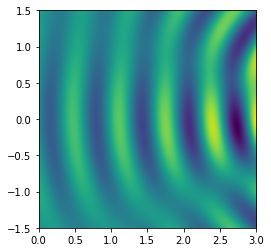

In [18]:
sources = np.array([[-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)],
                    [-1.2, np.random.uniform(-1,1), np.random.uniform(-1,1)]])

magnitudes = np.array([np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1)])


values = agf_cuda(10., sources, magnitudes)

plt.imshow(np.real(values), extent=[xmin, xmax, ymin, ymax])
plt.show()